# Data 620 Assignment 2 Week 3

Assignment 3: Graph Visualization
This week's assignment is to:
1. Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from https://snap.stanford.edu/data/), please feel free at this point to load just a small subset of the nodes and edges.
2. Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.
3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.
4. Please record a short video (~ 5 minutes), and submit a link to the video as part of your
homework submission.

In [111]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import io
import numpy as np
import collections


Tasked with loading a graph database and performing a basic analysis on the graph, I chose to import data from Baseball Databank--a compilation of historical baseball data.


In [112]:
data_folder = "https://github.com/PLombardo811/baseballdatabank/blob/master/upstream/"
Team_url = data_folder + "Teams.csv?raw=true"
Team_content = requests.get(Team_url).content
Team_csv = pd.read_csv(io.StringIO(Team_content.decode('utf-8')))

Data Cleaning:
To understand the data a summary of the first few lines of data was generated.

In [113]:
print(Team_csv.head())

   yearID lgID teamID franchID divID  Rank  Ghome DivWin WCWin LgWin WSWin  \
0    1871  NaN    BS1      BNA   NaN     3    NaN    NaN   NaN     N   NaN   
1    1871  NaN    CH1      CNA   NaN     2    NaN    NaN   NaN     N   NaN   
2    1871  NaN    CL1      CFC   NaN     8    NaN    NaN   NaN     N   NaN   
3    1871  NaN    FW1      KEK   NaN     7    NaN    NaN   NaN     N   NaN   
4    1871  NaN    NY2      NNA   NaN     5    NaN    NaN   NaN     N   NaN   

                      name                          park  attendance  BPF  \
0     Boston Red Stockings           South End Grounds I         NaN  103   
1  Chicago White Stockings       Union Base-Ball Grounds         NaN  104   
2   Cleveland Forest Citys  National Association Grounds         NaN   96   
3     Fort Wayne Kekiongas                Hamilton Field         NaN  101   
4         New York Mutuals      Union Grounds (Brooklyn)         NaN   90   

   PPF teamIDBR teamIDlahman45 teamIDretro  
0   98      BOS        

In [114]:
##The variable yearID had its values converted into strings.
Team_csv["yearID"] = Team_csv["yearID"].apply(str)

In [115]:
print(Team_csv.head())


  yearID lgID teamID franchID divID  Rank  Ghome DivWin WCWin LgWin WSWin  \
0   1871  NaN    BS1      BNA   NaN     3    NaN    NaN   NaN     N   NaN   
1   1871  NaN    CH1      CNA   NaN     2    NaN    NaN   NaN     N   NaN   
2   1871  NaN    CL1      CFC   NaN     8    NaN    NaN   NaN     N   NaN   
3   1871  NaN    FW1      KEK   NaN     7    NaN    NaN   NaN     N   NaN   
4   1871  NaN    NY2      NNA   NaN     5    NaN    NaN   NaN     N   NaN   

                      name                          park  attendance  BPF  \
0     Boston Red Stockings           South End Grounds I         NaN  103   
1  Chicago White Stockings       Union Base-Ball Grounds         NaN  104   
2   Cleveland Forest Citys  National Association Grounds         NaN   96   
3     Fort Wayne Kekiongas                Hamilton Field         NaN  101   
4         New York Mutuals      Union Grounds (Brooklyn)         NaN   90   

   PPF teamIDBR teamIDlahman45 teamIDretro  
0   98      BOS            BS

# Graph Generation

In [125]:
Rank_pairs = Team_csv[["Rank", "franchID"]].copy()
Rank_pairs["edges"] = Rank_pairs.apply(lambda x: (x["Rank"], x["franchID"]), axis=1)

I created a copy of the dataset using only the columns needed, Rank and franchID. These columns denote the Ranks of a given team and the franchise ID for that name. Using these columns, I was able to create a new column in the new variable, Rank_pairs, for the edges. These edges were recorded as tuples with the first item being the Rank and the second being the franchID.

In [126]:
G = nx.DiGraph()
G.add_edges_from(Rank_pairs["edges"].tolist())
G.add_nodes_from(Team_csv["Rank"].tolist()+Team_csv["franchID"].tolist())

To generate graph, the previously-created edges column was put it into list format, and then the Rank and franchID columns were put into list format and combined to make the nodes.

In [127]:
#The positions of the nodes were based on the spring layout.
pos = nx.spring_layout(G,k=1.55,iterations=100)

In [128]:
#Label Creation
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y)

In [129]:
for node in Team_csv["franchID"].tolist():
    G.node[node]["category"] = "franchise"
for node in Team_csv["Rank"].tolist():
    G.node[node]["category"] = "Rank"
color_map = {
    "franchise": "white",
    "Rank": "red"
}

Each node was assigned a category based off of its column name, and a map for colors was created based on whether or not the given node was categorized as a franchise or a Rank.
the plot was graphed where each node was colored based off of the category described and the edges were semi-transparent so as to be able to follow their paths more clearly.

/Users/rajans/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


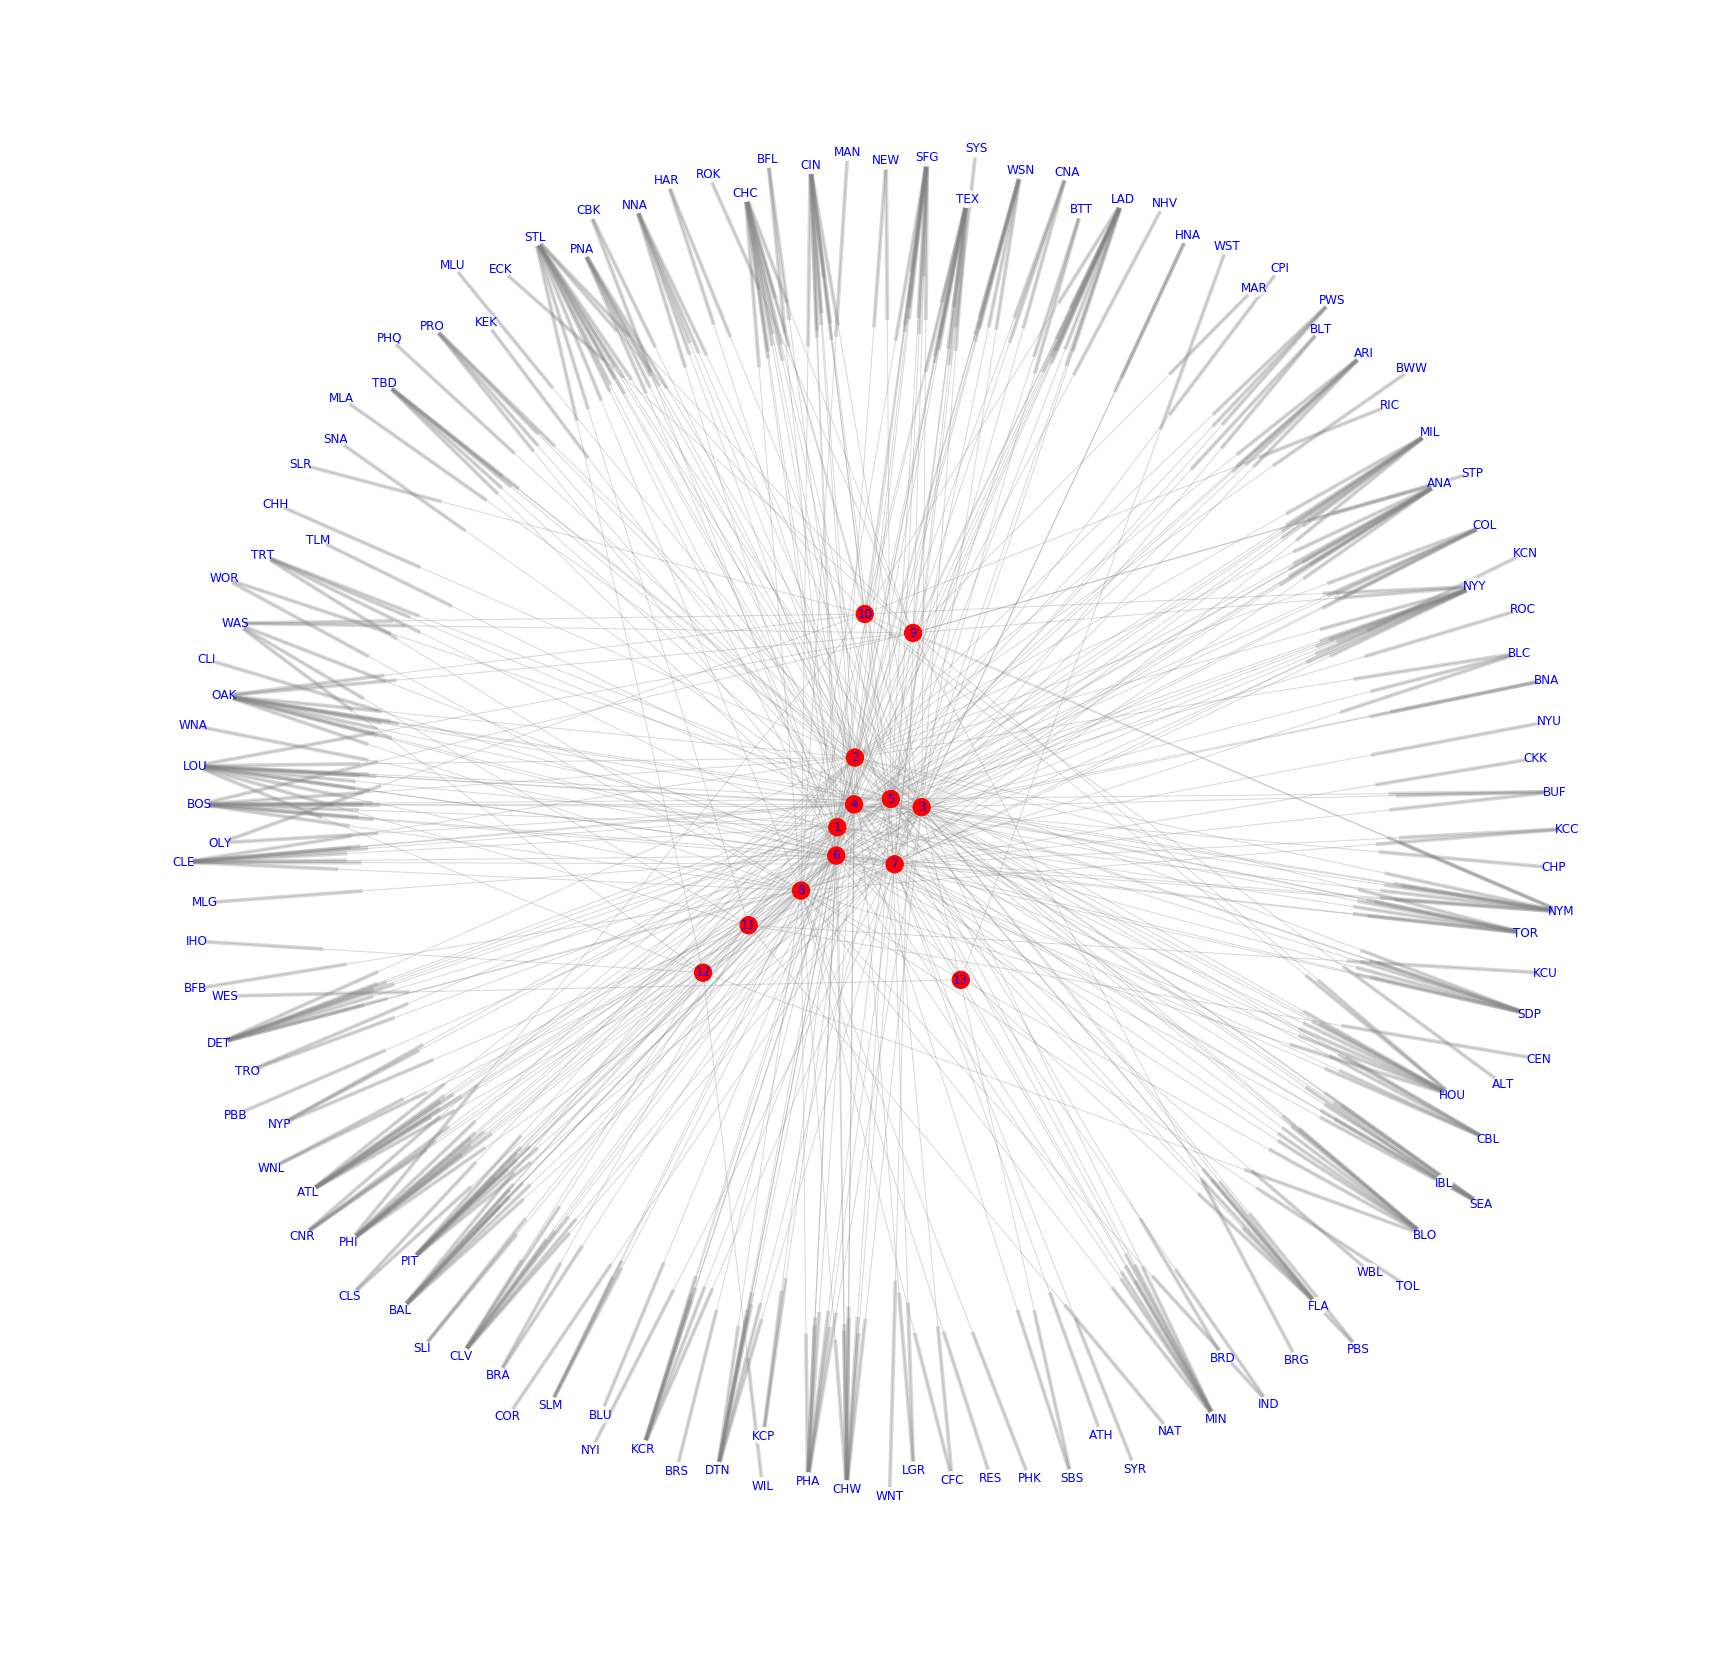

In [130]:
plt.figure(figsize=(30,30))
nx.draw_networkx_labels(G, pos=pos_labels, font_color='Blue')
nx.draw_networkx_edges(G, pos, edge_color="Grey", alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_color=[color_map[G.node[node]['category']] for node in G], node_size=300)
plt.axis('off')
plt.show()

# Finding the degree distribution
The degrees of each node is the number of connections it has to other nodes while the degree distribution represents the probability distribution of those degrees in the network.

Text(0.5, 0, 'Degree')

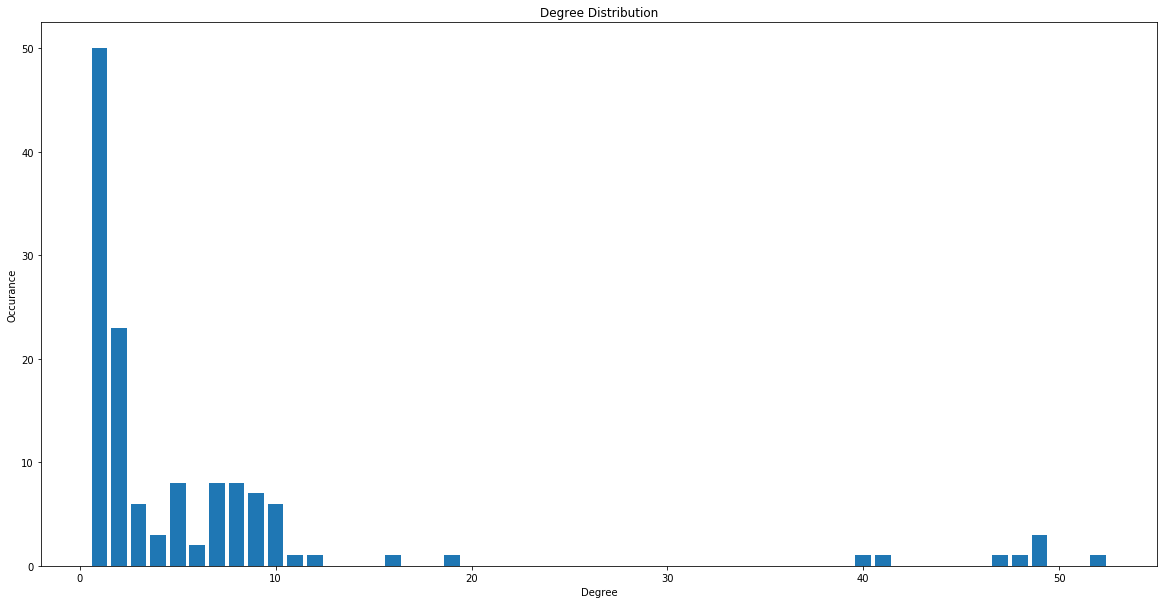

In [131]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
degrees, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degrees, count)

plt.title("Degree Distribution")
plt.ylabel("Occurance")
plt.xlabel("Degree")

# Finding the graph's diameter
The diameter of a network graph is the greatest path between two nodes.

In [132]:
G_undirected = G.to_undirected()
try:
    nx.diameter(G_undirected)
except Exception as e:
    print(e)
    print("There are a total of " + str(len(list(nx.isolates(G_undirected)))) + " isolated nodes")

Found infinite path length because the graph is not connected
There are a total of 0 isolated nodes


In [133]:
try:
    nx.diameter(G)
except Exception as e:
    print(e)
    print("There are a total of " + str(len(list(nx.isolates(G)))) + " isolated nodes")

Found infinite path length because the digraph is not strongly connected
There are a total of 0 isolated nodes


It is possible to calculate the diameter of the graph only if it is converted to an undirected graph.True directed graph, does not have a diameter because graph above isn't strongly connected as some nodes are disconnected rendering the diameter infinite. 